In [7]:
%matplotlib inline

import colorsys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )
import math

pd.set_option('max_colwidth', 200)

Loading BokehJS ...

In [86]:
lines       = pd.read_csv('london.lines.csv', index_col=0)
stations    = pd.read_csv('london.stations.removed.csv', index_col=0)
connections = pd.read_csv('london.connections.csv')

C:\Users\THMBa\Miniconda3\envs\py3iaml\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\THMBa\Miniconda3\envs\py3iaml\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


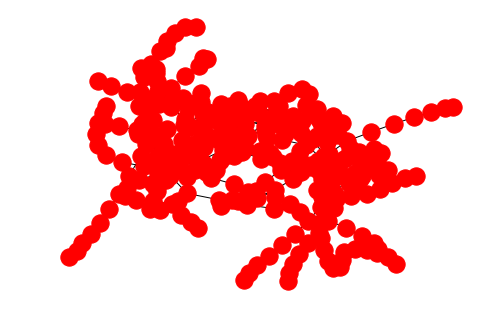

In [9]:
graph = nx.Graph()

for connection_id, connection in connections.iterrows():
    station1_name = stations.ix[connection['station1']]['name']
    station2_name = stations.ix[connection['station2']]['name']
    graph.add_edge(station1_name, station2_name, time = connection['time'])
    
#add the connection between Bank and Monument manually
graph.add_edge('Bank', 'Monument', time = 1)
nx.draw(graph)

In [10]:
nx.shortest_path(graph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Tottenham Court Road',
 'Holborn',
 'Chancery Lane',
 "St. Paul's",
 'Bank',
 'Shadwell',
 'Wapping',
 'Rotherhithe',
 'Canada Water',
 'Canary Wharf']

In [11]:
print(graph)

In [12]:
normed = stations[['longitude', 'latitude']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for edge in graph.edges():
    p.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
    )

for node in graph.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':node}, 
        text_font_size = str(10) +"pt",
        text_align='center',
        text_font_style='bold')
    
show(p)

In [15]:
nx.algorithms.connectivity.cuts.minimum_node_cut(graph)

{'Leytonstone'}

In [21]:
nx.algorithms.connectivity.stoerwagner.stoer_wagner(graph)

(1,
 (['Upminster'],
  ['Perivale',
   'Barking',
   'Warwick Avenue',
   'Gloucester Road',
   'Heron Quays',
   'Kentish Town',
   'Bethnal Green',
   'Kilburn',
   'Waterloo',
   'Island Gardens',
   'Baker Street',
   'Blackwall',
   "Regent's Park",
   'Grange Hill',
   'Pudding Mill Lane',
   'Mansion House',
   'Bromley-By-Bow',
   'West Harrow',
   'Tower Hill',
   'Ealing Common',
   'Kensal Green',
   'Picadilly Circus',
   'Boston Manor',
   "St. John's Wood",
   'New Cross',
   'East India',
   'Park Royal',
   'Fulham Broadway',
   'Northfields',
   'South Woodford',
   'Hainault',
   'Dagenham East',
   'Burnt Oak',
   'Russell Square',
   'Woodford',
   'Deptford Bridge',
   'High Street Kensington',
   'Hillingdon',
   'Kenton',
   'Golders Green',
   'Bounds Green',
   'Hendon Central',
   'Roding Valley',
   'Mudchute',
   'Parsons Green',
   'Bond Street',
   'Hyde Park Corner',
   'Ruislip',
   'Holloway Road',
   'Hammersmith',
   'Watford',
   'Greenford',
   'Tot

In [88]:
#math random 2 co-ordinates
import random

latcoors = stations['latitude']
longcoors = stations['longitude']
latmean = latcoors.mean()
longmean = longcoors.mean()

meancoors = (latmean, longmean)
print(meancoors)
longitudeBoundSize = 0.3
latitudeBoundSize = 0.3

randLat1 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
randLong1 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))
randLat2 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
randLong2 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))

#calculate distances to all stations in array from co-ordinates
distances1 = []
distances2 = []
for i in range(1, len(stations['longitude'])):
    #print(stations['name'].iloc[i-1])
    print(i)
    print(stations['latitude'].iloc[i-1])
    distance1 = math.sqrt((randLat1 - stations['latitude'].iloc[i-1])**2 + (randLong1 - stations['longitude'].iloc[i-1])**2)
    distance2 = math.sqrt((randLat2 - stations['latitude'].iloc[i-1])**2 + (randLong2 - stations['longitude'].iloc[i-1])**2)
    print(distance1)
    
    distances1.append(distance1)
    distances2.append(distance2)

#pick shorest for each co-ordinate
print(distances1.index(distances1[6]))
station1 = distances1.index(min(distances1))
station2 = distances2.index(min(distances2))
print(station1)
print(randLat1, randLong1)
print(distances1[station1])
print(stations['name'][station1+1])

#calculate shortest time taken to travel between 2 the 2 stations (Djikstras)
#return this value

(51.53436589403974, -0.15316688741721854)
1
51.5028
0.17357092140550864
2
51.5143
0.1457176108582468
3
51.5154
0.1466081852238508
4
51.5107
0.19215183562425006
5
51.5407
0.16380677237091465
6
51.6736
0.44610976454098406
7
51.5322
0.11401797603618481
8
51.5653
0.07115424048717611
9
51.6164
0.0331630487960445
10
51.5586
0.09206569862973905
11
51.5226
0.10842316548356742
12
51.4431
0.18805578838129292
13
51.5133
0.13909848572797276
14
51.5204
0.12819164938020058
15
51.5396
0.26045540357591807
16
51.5856
0.2556805988400337
17
51.4905
0.14932937594728243
18
51.5121
0.12135978787600236
19
51.5148
0.25249874940986816
20
51.5087
0.24984609905670538
21
51.5403
0.30375710593384436
22
51.5504
0.08047551153524221
23
51.4979
0.1659180591378903
24
51.527
0.1498702954474345
25
51.512
0.1330792536802026
26
51.5867
0.12903556469073124
27
51.5079
0.1989052803338424
28
51.5142
0.11744896603048355
29
51.5011
0.1468019920409124
30
51.4956
0.21109161116174394
31
51.6071
0.04536512705417951
32
51.5273
0.1758